In [1]:
from pathlib import Path
import robot_vlp.robot as r

from loguru import logger
from tqdm import tqdm
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from robot_vlp.config import MODELS_DIR, PROCESSED_DATA_DIR,EXTERNAL_DATA_DIR, INTERIM_DATA_DIR

from robot_vlp.modeling.train_mlp import ang_loss_fn
import robot_vlp.data.preprocessing as p
import robot_vlp.data.odometer_path_navigation as pg
import robot_vlp.plots.model_performance_plotting as pp

import robot_vlp.modeling.rnn as trn


%load_ext autoreload
%autoreload 2

2024-11-30 11:37:38.482 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


In [2]:
model = keras.models.load_model(MODELS_DIR / 'odometer_trained_rnn.keras',custom_objects={"ang_loss_fn": ang_loss_fn})



X_scaler = p.build_scaler()
vlp_model_dic = pg.read_vlp_models()


vlp_dataset_path = EXTERNAL_DATA_DIR / "vlp_dataset.csv"
df = pd.read_csv(vlp_dataset_path, index_col=0)


# def ang_loss_fn(y_true, y_pred):
#     return keras.losses.cosine_similarity(y_true, y_pred) + 1


def make_prediction(X):
    return model.predict(np.expand_dims(X,0), verbose = None)

2024-11-18 16:45:24.261234: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-18 16:45:24.261312: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-18 16:45:24.261332: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-18 16:45:24.261658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-18 16:45:24.261701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it h

In [3]:
import robot_vlp.data.live_navigation as ln


def navigate_to_target(robot,x,y,step_size = 0.1, target_threshold = 0.1):
    robot.target_x = x
    robot.target_y = y
    window_len = model.input_shape[1]
    if window_len == None:
         window_len = 40

    robot.navigation_method = 'odometer'
    while (robot.calc_distance_to_target() > target_threshold) & pg.in_bounds(robot,x_lim=(0.5,6.5), y_lim = (0.5,5.7)):
        
        robot.correct_heading()
        robot.step(step_size)
        if len(robot.x_hist) >= window_len:
                # continue
                robot.navigation_method = 'model'

                X_data = np.array([robot.encoder_x_hist[-window_len:], robot.encoder_y_hist[-window_len:], robot.encoder_heading_hist[-window_len:], robot.vlp_x_hist[-window_len:], robot.vlp_y_hist[-window_len:], robot.vlp_heading_hist[-window_len:]]).T
                X_data = X_scaler.transform(X_data)

                pre = make_prediction(X_data)
                robot.model_x = pre[0][0,0]
                robot.model_y = pre[0][0,1]
                robot.model_heading = p.vector_to_ang(pre[1], unit = 'degrees').numpy()[0]
                robot.model_x_hist.append(robot.model_x)
                robot.model_y_hist.append(robot.model_y)
                robot.model_heading_hist.append(robot.model_heading)
        else:
                robot.model_heading_hist.append(robot.encoder_heading)
                robot.model_x_hist.append(robot.encoder_x)
                robot.model_y_hist.append(robot.encoder_y)

In [7]:
with open(INTERIM_DATA_DIR/'navigation_paths.pkl', 'rb') as f:
    target_paths = pickle.load( f)

In [8]:
target_paths['n_10_rad_1-5_anticlockwise']

array([[4.56066017, 4.06066017],
       [4.98153251, 3.2346517 ],
       [4.83650979, 2.31901425],
       [4.18098575, 1.66349021],
       [3.2653483 , 1.51846749],
       [2.43933983, 1.93933983],
       [2.01846749, 2.7653483 ],
       [2.16349021, 3.68098575],
       [2.81901425, 4.33650979],
       [3.7346517 , 4.48153251]])

In [14]:
model = keras.models.load_model(MODELS_DIR / 'odometer_trained_rnn.keras',custom_objects={"ang_loss_fn": ang_loss_fn})

vlp_model = vlp_model_dic['high_acc']


err_val = 0.01
turn_err = 0.01

start_x = 1
start_y = 1
start_heading = 45
robot = r.Robot(x=start_x, y=start_y, heading =start_heading, step_err = err_val, turn_err = err_val, df = df, vlp_mod = vlp_model,navigation_method = 'odometer')  

ln.navigate_to_target(robot, x = 5, y = 5, model = model)


nav_path = target_paths['n_5_rad_1_anticlockwise']
for i in range(len(nav_path)):
    x = nav_path[i,0]
    y = nav_path[i,1]
    ln.navigate_to_target(robot, x = x, y = y, model = model)




/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
model.load_weights('rnn_checkpoints.weights.h5')

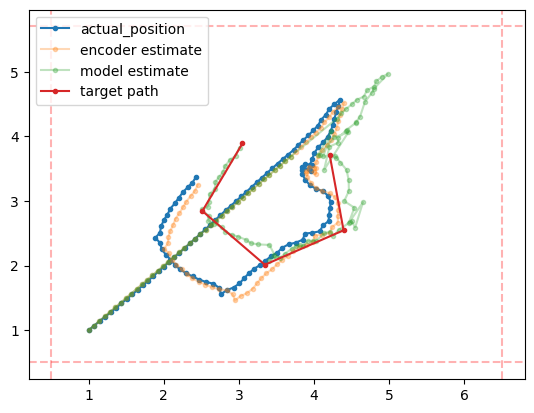

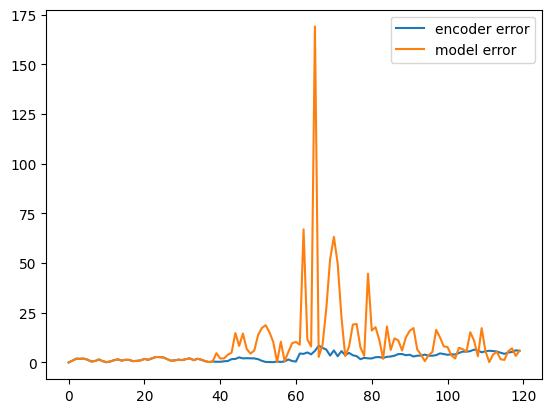

In [15]:
plt.plot(robot.x_hist, robot.y_hist, label = 'actual_position', marker = '.')
plt.plot(robot.encoder_x_hist, robot.encoder_y_hist, label = 'encoder estimate', marker = '.', alpha = 0.3)
plt.plot(robot.model_x_hist,robot.model_y_hist, label = 'model estimate', marker = '.', alpha = 0.3)
# plt.plot(robot.vlp_x_hist, robot.vlp_y_hist, marker = '.', label = 'vlp position')
plt.plot(nav_path[:,0], nav_path[:,1], label = 'target path', marker = '.')

plt.axhline(0.5, c = 'r', ls = '--', alpha = 0.3)
plt.axhline(5.7, c = 'r', ls = '--', alpha = 0.3)
plt.axvline(0.5, c = 'r', ls = '--', alpha = 0.3)
plt.axvline(6.5, c = 'r', ls = '--', alpha = 0.3)
plt.legend()

plt.figure()
# plt.plot(robot.encoder_heading_hist)
# plt.plot(np.array(robot.heading_hist[:]) -np.array(robot.model_heading_hist), label = 'model error')



plt.plot(np.abs(pp.min_ang_diff(np.array(robot.encoder_heading_hist[:]) , np.array(robot.heading_hist[:]))), label = 'encoder error')
plt.plot(np.abs(pp.min_ang_diff(np.array(robot.model_heading_hist[:]) , np.array(robot.heading_hist[:]))), label = 'model error')
# plt.plot(robot.model_heading_hist)
# plt.plot(robot.vlp_heading_hist)
# plt.axhline(180, c = 'r')
plt.legend()

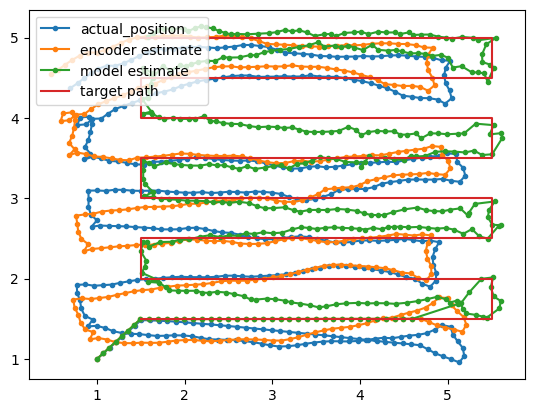

In [16]:


err_val = 0.01
turn_err = 0.01

start_x = 1
start_y = 1
start_heading = 0
robot = r.Robot(x=start_x, y=start_y, heading =start_heading, step_err = err_val, turn_err = err_val, df = df, vlp_mod = vlp_model,navigation_method = 'odometer')  

ys = np.arange(1.5,5.5,0.5).repeat(2)
xs = np.tile([1.5,1.5,5.5,5.5], 7)[1:len(ys)+1]
for i in range(len(ys)):
    navigate_to_target(robot, x = xs[i], y = ys[i])


plt.plot(robot.x_hist, robot.y_hist, label = 'actual_position', marker = '.')
plt.plot(robot.encoder_x_hist, robot.encoder_y_hist, label = 'encoder estimate', marker = '.')
plt.plot(robot.model_x_hist,robot.model_y_hist, label = 'model estimate', marker = '.')
# plt.scatter([2,2,4,4],[2,4,2,4])
# plt.plot(robot.vlp_x_hist, robot.vlp_y_hist, marker = '.', label = 'vlp position')
plt.plot(xs, ys, label = 'target path')
plt.legend()

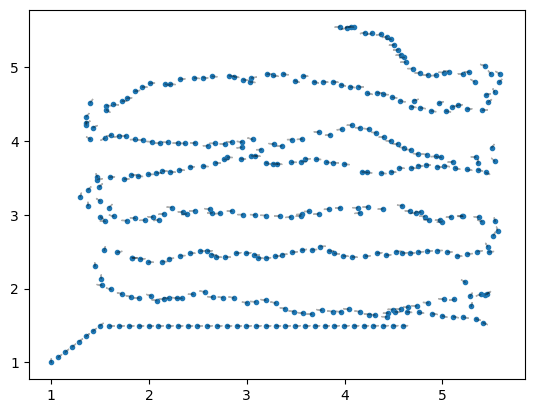

In [476]:
arrow_len = 0.05
dy = np.cos((np.array(robot.model_heading_hist))/180*np.pi) * arrow_len
dx = np.sin((np.array(robot.model_heading_hist))/180*np.pi) * arrow_len
# x = robot.x_hist[9:]
# y = robot.y_hist[9:]

x = robot.model_x_hist
y = robot.model_y_hist

plt.scatter(x, y, marker = '.')
for i in range(len(x)):
    plt.arrow(x[i], y[i], dx[i], dy[i], alpha = 0.3)


# dy = np.cos((np.array(robot.heading_hist))/180*np.pi) * arrow_len
# dx = np.sin((np.array(robot.heading_hist))/180*np.pi) * arrow_len
# x = robot.x_hist[11:]
# y = robot.y_hist[11:]

# x = robot.model_x_hist
# y = robot.model_y_hist

# plt.plot(x, y, marker = '.')
# for i in range(len(x)):
#     plt.arrow(x[i], y[i], dx[i], dy[i])

In [431]:
import robot_vlp.plots.entire_dataset_model_offline_performance_plot as pf

rnn_model = keras.models.load_model(MODELS_DIR / 'model_02.keras',custom_objects={"ang_loss_fn": ang_loss_fn})

name = 'windowed_live_model_dataset.pickle'
with open(PROCESSED_DATA_DIR /name, 'rb') as f:
    odometer_windowed_data = pickle.load(f)

In [17]:
x_win = odometer_windowed_data['X_train']
y_win = odometer_windowed_data['y_train']
m_win = odometer_windowed_data['m_train']

stats = pf.test_model(x_win, y_win, model, 'testplot')

NameError: name 'odometer_windowed_data' is not defined

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


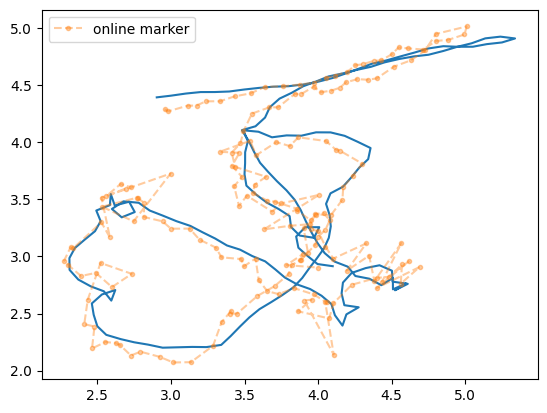

In [463]:
s = 0
e = 180


pre = rnn_model.predict(x_win[s:e+1])[0]

plt.plot(y_win[s:e, 0], y_win[s:e, 1])
plt.plot(m_win[s:e, 0], m_win[s:e, 1], marker = '.', alpha = 0.4, ls = '--', label = 'online marker')
# plt.plot(pre[:,0], pre[:,1], marker = '.', alpha = 0.4, ls = '-', label = 'model just run')
plt.legend()

In [606]:
def unpack_path_run(data, path_no, skip_start = 0):
    b = skip_start

    output_data  = {}
    output_data['odo_x'] = data['X_test_data'][path_no][b:,0]
    output_data['odo_y'] = data['X_test_data'][path_no][b:,1]
    output_data['odo_heading'] = data['X_test_data'][path_no][b:,2]
    output_data['vlp_x'] = data['X_test_data'][path_no][b:,3]
    output_data['vlp_y'] = data['X_test_data'][path_no][b:,4]
    output_data['vlp_heading'] = data['X_test_data'][path_no][b:,5]

    output_data['x'] = data['y_test_data'][path_no][b:,0]
    output_data['y'] = data['y_test_data'][path_no][b:,1]
    output_data['heading'] = data['y_test_data'][path_no][b:,2]

    output_data['model_x'] = data['m_test_data'][path_no][b:,0]
    output_data['model_y'] = data['m_test_data'][path_no][b:,1]
    output_data['model_heading'] = data['m_test_data'][path_no][b:,2]
    return output_data

def calc_single_path_errs(data, path_no, skip_start = 0):
    output_data = {}
    unpacked_data = unpack_path_run(data, path_no, skip_start)

    output_data['model_dist_err'] = np.sqrt(np.square(unpacked_data['x'] - unpacked_data['model_x']) + np.square(unpacked_data['y'] - unpacked_data['model_y']))
    output_data['model_heading_err'] = np.abs(pp.min_ang_diff(unpacked_data['model_heading'] , unpacked_data['heading']))


    return output_data

def calc_all_path_errs(data, skip_start = 0):
    output_data = {}
    heading_errs = []
    distance_errs = []
    for i in range(len(data['X_test_data'])):
        errs = calc_single_path_errs(data, i, skip_start)
        heading_errs.append(errs['model_heading_err'])
        distance_errs.append(errs['model_dist_err'])
    output_data['heading_errs'] = np.concatenate(heading_errs)
    output_data['distance_errs'] = np.concatenate(distance_errs)
    return output_data

def print_errs(errs):
    print('dist err: ',errs['distance_errs'].mean())
    print('dist std: ',np.std(errs['distance_errs']))
    print('heading err: ',errs['heading_errs'].mean())
    print('heading std: ',np.std(errs['heading_errs']))

In [609]:
name = 'windowed_live_model_dataset.pickle'
with open(PROCESSED_DATA_DIR /name, 'rb') as f:
    data = pickle.load(f)
print_errs(calc_all_path_errs(data, skip_start= 40 ))

dist err:  0.19918840487239467
dist std:  0.1604994972800579
heading err:  20.21171236947935
heading std:  28.670233436318767


In [610]:
rnn_model_02 = keras.models.load_model(MODELS_DIR / 'model_02.keras',custom_objects={"ang_loss_fn": ang_loss_fn})

In [614]:
rnn_model_03 = keras.models.clone_model(rnn_model_02)
rnn_model_03.compile(optimizer='adam',
        loss = ['mse',ang_loss_fn],
            loss_weights = [1., 1.],
        )
rnn_model_03.save(MODELS_DIR/'rnn_model_03.keras')

trn.retrain_model('rnn_model_03.keras', 'windowed_live_model_dataset.pickle')

Epoch 1/2000


/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 28 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - heading_loss: 0.6837 - loss: 2.2436 - pos_loss: 1.5599 - val_heading_loss: 0.2631 - val_loss: 0.3303 - val_pos_loss: 0.0678
Epoch 2/2000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - heading_loss: 0.3089 - loss: 0.3829 - pos_loss: 0.0740 - val_heading_loss: 0.2212 - val_loss: 0.2615 - val_pos_loss: 0.0409
Epoch 3/2000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - heading_loss: 0.3477 - loss: 0.4374 - pos_loss: 0.0897 - val_heading_loss: 0.2379 - val_loss: 0.2936 - val_pos_loss: 0.0563
Epoch 4/2000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - heading_loss: 0.3883 - loss: 0.4793 - pos_loss: 0.0909 - val_heading_loss: 0.3506 - val_loss: 0.3936 - val_pos_loss: 0.0438
Epoch 5/2000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - heading_loss: 0.2978 - loss: 0.3468 - pos_loss: 0.0491 - val_heading_loss: 0.7071 - val_loss: 0.7861 - val_pos_loss: 0.0843
Epoch 6/2000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - heading_loss: 0.3789 - loss: 0.4325 - pos_loss: 0.0535 - 

In [629]:
# use model to generate paths
subprocess.call(['python','../../robot_vlp/modeling/live_navigation.py','rnn_model_03.keras','generated_paths.pkl','live_dataset_03'])

2024-11-15 11:53:13.935 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


2024-11-15 11:53:14.559 | INFO     | __main__:main:53 - Reading in VLP dataset
2024-11-15 11:53:14.578 | SUCCESS  | __main__:main:56 - Pulled in VLP dataset
2024-11-15 11:53:14.626 | INFO     | __main__:main:84 - Starting run n_2_rad_1_clockwise
2024-11-15 11:53:26.130 | INFO     | __main__:main:84 - Starting run n_2_rad_1_anticlockwise
2024-11-15 11:53:38.061 | INFO     | __main__:main:84 - Starting run n_2_rad_1_shuffle
2024-11-15 11:53:49.543 | INFO     | __main__:main:84 - Starting run n_2_rad_1-5_clockwise
2024-11-15 11:54:09.735 | INFO     | __main__:main:84 - Starting run n_2_rad_1-5_anticlockwise
2024-11-15 11:54:27.841 | INFO     | __main__:main:84 - Starting run n_2_rad_1-5_shuffle
2024-11-15 11:54:44.971 | INFO     | __main__:main:84 - Starting run n_2_rad_2_clockwise
2024-11-15 11:55:09.573 | INFO     | __main__:main:84 - Starting run n_2_rad_2_anticlockwise
2024-11-15 11:55:31.980 | INFO     | __main__:main:84 - Starting run n_2_rad_2_shuffle
2024-11-15 11:55:53.616 | INFO

0

In [637]:
# preprocess path data ready for training
subprocess.call(['python','../../robot_vlp/data/preprocessing.py','live_dataset_03','live_dataset_03_processed.plk'])


2024-11-15 12:57:05.209 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


0

In [638]:
name = 'live_dataset_03_processed.plk'
with open(PROCESSED_DATA_DIR /name, 'rb') as f:
    data = pickle.load(f)
print_errs(calc_all_path_errs(data, skip_start= 40 ))

dist err:  0.11903700040386994
dist std:  0.09726932248598157
heading err:  16.89076312652829
heading std:  16.665904038448193


In [671]:
rnn_model_04 = keras.models.clone_model(rnn_model_03)
rnn_model_04.compile(optimizer='adam',
        loss = ['mse',ang_loss_fn],
            loss_weights = [1., 10.],
        )
rnn_model_04.save(MODELS_DIR/'rnn_model_04.keras')

trn.retrain_model('rnn_model_04.keras', 'live_dataset_03_processed.plk')

Epoch 1/2000


/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 28 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - heading_loss: 6.2671 - loss: 8.2145 - pos_loss: 1.9473 - val_heading_loss: 2.5660 - val_loss: 2.9855 - val_pos_loss: 0.4224
Epoch 2/2000
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - heading_loss: 2.4532 - loss: 2.9191 - pos_loss: 0.4659 - val_heading_loss: 1.8257 - val_loss: 2.1426 - val_pos_loss: 0.3186
Epoch 3/2000
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - heading_loss: 1.7703 - loss: 2.1412 - pos_loss: 0.3708 - val_heading_loss: 1.9232 - val_loss: 2.2153 - val_pos_loss: 0.2921
Epoch 4/2000
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - heading_loss: 1.3679 - loss: 1.6423 - pos_loss: 0.2744 - val_heading_loss: 1.0776 - val_loss: 1.2130 - val_pos_loss: 0.1383
Epoch 5/2000
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - heading_loss: 1.2160 - loss: 1.3628 - pos_loss: 0.1469 - val_heading_loss: 1.2090 - val_loss: 1.3296 - val_pos_loss: 0.1239
Epoch 6/2000
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - heading_loss: 1.1790 - loss: 1.2853 - pos_loss: 0.1063 

In [640]:
# use model to generate paths
subprocess.call(['python','../../robot_vlp/modeling/live_navigation.py','rnn_model_04.keras','generated_paths.pkl','live_dataset_04'])

2024-11-15 13:24:02.844 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


2024-11-15 13:24:03.576 | INFO     | __main__:main:53 - Reading in VLP dataset
2024-11-15 13:24:03.601 | SUCCESS  | __main__:main:56 - Pulled in VLP dataset
2024-11-15 13:24:03.663 | INFO     | __main__:main:84 - Starting run n_2_rad_1_clockwise
2024-11-15 13:24:15.967 | INFO     | __main__:main:84 - Starting run n_2_rad_1_anticlockwise
2024-11-15 13:24:30.820 | INFO     | __main__:main:84 - Starting run n_2_rad_1_shuffle
2024-11-15 13:24:43.932 | INFO     | __main__:main:84 - Starting run n_2_rad_1-5_clockwise
2024-11-15 13:25:00.877 | INFO     | __main__:main:84 - Starting run n_2_rad_1-5_anticlockwise
2024-11-15 13:25:17.875 | INFO     | __main__:main:84 - Starting run n_2_rad_1-5_shuffle
2024-11-15 13:25:36.479 | INFO     | __main__:main:84 - Starting run n_2_rad_2_clockwise


/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


KeyboardInterrupt: 

In [ ]:
# preprocess path data ready for training
subprocess.call(['python','../../robot_vlp/data/preprocessing.py','live_dataset_04','live_dataset_04_processed.plk'])


In [ ]:
name = 'live_dataset_04_processed.plk'
with open(PROCESSED_DATA_DIR /name, 'rb') as f:
    data = pickle.load(f)
print_errs(calc_all_path_errs(data, skip_start= 40 ))

In [696]:
name = 'odometer_navigated_data.pkl'
with open(PROCESSED_DATA_DIR /name, 'rb') as f:
    data = pickle.load(f)

In [705]:
data.keys()

dict_keys(['train_files', 'valid_files', 'test_files', 'X_train_data', 'X_valid_data', 'X_test_data', 'y_train_data', 'y_valid_data', 'y_test_data', 'm_train_data', 'm_test_data', 'm_valid_data', 'X_train', 'X_valid', 'X_test', 'y_train', 'y_valid', 'y_test', 'm_train', 'm_valid', 'm_test'])

In [701]:
data['X_train'].shape

(391567, 40, 6)

In [702]:
import sys

In [711]:
sys.getsizeof(data)

640